# Desafío 03: Modelo de lenguaje con redes recurrentes

## 1. Introducción y objetivos
El objetivo de este desafío es construir un **Modelo de Lenguaje (Language Model)** a nivel de caracteres utilizando arquitecturas de redes neuronales recurrentes (**SimpleRNN, LSTM y GRU**).

El dataset proviene de un corpus de textos científicos (*Natural and Physical Sciences*). Dado que trabajar a nivel de caracteres presenta desafíos únicos (como la longitud de las secuencias y la diversidad de símbolos en textos científicos), este notebook se enfoca en una estrategia de **preprocesamiento robusto** priorizando la calidad de los datos sobre la cantidad.

### Estrategia de preprocesamiento:
1.  **Limpieza y filtrado:** en lugar de tokenizar todos los caracteres (lo que resultaría en un vocabulario enorme y ruidoso de >3000 tokens), definiremos una "lista blanca" (*allowlist*) de caracteres frecuentes. Todo documento que contenga caracteres fuera de esta lista será descartado.
2.  **Manejo de contexto:** utilizaremos un token especial (`EOS` - *End of Sequence*) para marcar el final de los documentos, permitiendo al modelo aprender cuándo concluir una idea.
3.  **Eficiencia:** Se utilizarán generadores de datos (`tf.keras.utils.Sequence`) para evitar cargar estructuras redundantes en memoria RAM.

## 2. Configuración e importaciones

Definimos las librerías necesarias y los **hiperparámetros globales** del proyecto.
Se ha seleccionado un tamaño de vocabulario (`VOCAB_LIMIT`) reducido para eliminar ruido (emojis, caracteres raros, notación matemática compleja mal codificada) y facilitar la convergencia del modelo.

In [4]:
import os
import re
import numpy as np
import tensorflow as tf
import unicodedata
import random
import datetime
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.special import softmax 
from tensorflow.keras.models import load_model


SEQ_LEN = 100           # Contexto
BATCH_SIZE = 128        
EMBEDDING_DIM = 256     # Dimensión del vector
RNN_UNITS = 256         # Unidades por capa
VOCAB_LIMIT = 150       # Top caracteres a conservar
EPOCHS = 10             # Épocas por modelo

BASE_PATH = "data/Natural_and_physical_sciences/"
FILES = ["train.txt", "valid.txt"]
LOG_DIR = "logs/fit/"   # Carpeta para TensorBoard

SEPARATOR = "<|endofdoc|>"
UNK_TOKEN = "<|unk|>" 
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "\x03"      # Token invisible para fin de documento

## 3. Análisis de frecuencias y definición de caracteres permitidos

Antes de procesar los textos, realizamos un barrido estadístico del corpus para identificar qué caracteres son realmente relevantes.
Textos científicos suelen tener mucho "ruido" en forma de notación matemática o caracteres unicode extraños. Si incluimos todos, la capa de salida del modelo (Softmax) se vuelve ineficiente y el modelo desperdicia capacidad intentando predecir símbolos que aparecen una sola vez.

**Decisión:** conservaremos solo los N caracteres más frecuentes (letras, números, puntuación básica) y descartaremos cualquier documento que no cumpla con este estándar.

In [7]:
def get_allowed_characters(files, base_path, limit):
    print("[INFO] Analizando frecuencias de caracteres...")
    counter = Counter()
    
    for filename in files:
        path = os.path.join(base_path, filename)
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8", errors="replace") as f:
                for line in f:
                    line = unicodedata.normalize("NFC", line)
                    counter.update(line)
    
    # Nos quedamos con los más frecuentes
    most_common = counter.most_common(limit)
    allowed_chars = set(char for char, count in most_common)
    
    # Aseguramos caracteres críticos
    required = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,;:-_()[]!?\n ")
    allowed_chars.update(required)
    
    print(f"[INFO] Caracteres permitidos ({len(allowed_chars)}): {sorted(list(allowed_chars))}")
    return allowed_chars

ALLOWED_CHARS = get_allowed_characters(FILES, BASE_PATH, VOCAB_LIMIT)

[INFO] Analizando frecuencias de caracteres...
[INFO] Caracteres permitidos (150): ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\xa0', '°', '±', '²', 'Å', '×', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ë', 'í', 'ñ', 'ó', 'õ', 'ö', 'ø', 'ú', 'ü', 'ā', 'č', 'ī', 'ł', 'Ō', 'ō', 'š', 'ū', 'ž', 'α', 'β', 'ι', 'λ', 'μ', 'ν', 'ο', 'ρ', 'ς', 'а', 'е', 'и', 'н', 'о', 'р', 'ا', '–', '—', '‘', '’', '“', '”', '−']


## 4. Filtrado y generación de dataset limpio

En esta etapa generamos nuevos archivos (`.clean_filtered`). La lógica:
1.  Se normaliza el texto (Unicode NFC).
2.  Se eliminan etiquetas de fórmulas conocidas.
3.  **Filtrado:** se verifica cada documento contra nuestra *allowlist*. Si un documento contiene aunque sea un solo caracter "ilegal" (ruido), se descarta por completo.

Esto garantiza que el dataset de entrenamiento sea **100% coherente** con el vocabulario del modelo, eliminando la necesidad de que el modelo aprenda a manejar tokens desconocidos (`<UNK>`). Además, insertamos el separador textual `<|endofdoc|>` para delimitar visualmente los documentos.

In [8]:
def clean_line(line):
    line = unicodedata.normalize("NFC", line)
    line = re.sub(r"formula_\d+", "", line)  # Eliminar fórmulas
    line = re.sub(r"[ \t]+", " ", line)       # Colapsar espacios
    return line

def is_document_title(line):
    if not line: return False
    if not line[0].isupper(): return False
    if line.endswith("."): return False
    if len(line.split()) > 12: return False
    return True

def save_document_if_clean(doc_lines, allowed_set, fout):
    full_text = "".join(doc_lines)
    # Verificamos si hay algún caracter fuera de los permitidos
    if len(set(full_text) - allowed_set) > 0:
        return False # Documento sucio, descartar
    
    fout.write(full_text)
    fout.write(SEPARATOR + "\n\n")
    return True

def process_and_filter_files(files, base_path, allowed_chars):
    processed_files = []
    
    for filename in files:
        in_path = os.path.join(base_path, filename)
        out_path = os.path.join(base_path, filename + ".clean_filtered")
        processed_files.append(out_path)
        
        if not os.path.exists(in_path): continue
        if os.path.exists(out_path): 
            continue

        print(f"   Procesando: {filename} ...")
        with open(in_path, "r", encoding="utf-8", errors="replace") as fin, \
             open(out_path, "w", encoding="utf-8") as fout:
            
            doc_buffer = []
            empty_count = 0
            kept = 0
            discarded = 0
            
            for raw_line in fin:
                line = clean_line(raw_line)
                stripped = line.strip()
                
                # Heurística de inicio de documento
                is_new_doc = False
                if stripped == "":
                    empty_count += 1
                else:
                    if empty_count >= 1 and is_document_title(stripped):
                        is_new_doc = True
                    empty_count = 0
                
                if is_new_doc and doc_buffer:
                    if save_document_if_clean(doc_buffer, allowed_chars, fout): kept += 1
                    else: discarded += 1
                    doc_buffer = []
                
                doc_buffer.append(line)
            
            # Último documento
            if doc_buffer:
                if save_document_if_clean(doc_buffer, allowed_chars, fout): kept += 1
                else: discarded += 1
                        
    return processed_files

CLEAN_FILES = process_and_filter_files(FILES, BASE_PATH, ALLOWED_CHARS)

## 5. Tokenización y construcción del vocabulario

Aquí transformamos el texto en secuencias numéricas.

**Estrategia del separador (`EOS`):** aunque en el archivo de texto usamos `<|endofdoc|>` para que sea legible por humanos, para la red neuronal esto es ineficiente (tendría que aprender a predecir la secuencia `<`,`|`,`e`,`n`... caracter por caracter).
Por lo tanto, durante la tokenización, reemplazamos toda la cadena `<|endofdoc|>` por un **único token especial** (`EOS_TOKEN`, asignado al ID 2).

Esto simplifica la tarea del modelo: para terminar un documento, solo debe predecir un ID específico.

In [9]:
def build_vocab(paths):
    chars = set()
    for path in paths:
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                # Limpiamos el separador para que no meta ruido en el vocabulario de caracteres
                line_clean = line.replace(SEPARATOR, "")
                chars.update(line_clean)
    
    # Ordenar
    vocab = sorted(list(chars))
    
    # Crear mapas. Reservamos los primeros índices para tokens especiales
    # 0: PAD, 1: UNK, 2: EOS (Fin de documento)
    char2idx = {char: i + 3 for i, char in enumerate(vocab)}
    
    char2idx[PAD_TOKEN] = 0
    char2idx[UNK_TOKEN] = 1
    char2idx[EOS_TOKEN] = 2  # Asignamos un ID único al final de documento
    
    idx2char = {i: c for c, i in char2idx.items()}
    return char2idx, idx2char

# Reconstruimos vocabulario
char2idx, idx2char = build_vocab(CLEAN_FILES)
VOCAB_SIZE = len(char2idx)
print(f"[INFO] Tamaño vocabulario: {VOCAB_SIZE}")
print(f"[INFO] ID del Separador (EOS): {char2idx[EOS_TOKEN]}")

[INFO] Tamaño vocabulario: 146
[INFO] ID del Separador (EOS): 2


In [ ]:
def tokenize_file(path, char2idx):
    tokens = []
    unk_idx = char2idx[UNK_TOKEN]
    eos_char = EOS_TOKEN 
    
    with open(path, "r", encoding="utf-8") as f:
        content = f.read()
        
        content = content.replace(SEPARATOR, eos_char)
        
        # Tokenizamos caracter por caracter
        # Si encuentra el eos_char, le asignará el ID 2 automáticamente
        tokens = [char2idx.get(c, unk_idx) for c in content]
        
    return np.array(tokens, dtype=np.int32)

train_tokens = tokenize_file(CLEAN_FILES[0], char2idx)
val_tokens   = tokenize_file(CLEAN_FILES[1], char2idx)


In [5]:
def debug_tokenization(tokens, char2idx, idx2char, sample_len=200):   
    print(f"Tokens totales: {len(tokens):,}")
    start = random.randint(0, len(tokens) - sample_len)
    sample = tokens[start:start+sample_len]
    text = "".join([idx2char[i] for i in sample])
    
    print("\n--- Muestra de Texto Reconstruido ---")
    print(sample)
    print(text)
    print("-------------------------------------")

debug_tokenization(train_tokens, char2idx, idx2char)

Tokens totales: 45,272,090

--- Muestra de Texto Reconstruido ---
[ 70  82  79  71   4  72  65  83   4  66  69  69  78   4  67  79  73  78
  69  68   4  70  79  82   4  84  72  73  83   4  83  80  69  67  73  69
  83  16   4  73  78   4  82  69  70  69  82  69  78  67  69   4  84  79
   4  40  68  85  65  82  68   4  50  83  67  65  82   4  54  67  72  77
  73  68  84   4  87  72  79   4  68  69  83  67  82  73  66  69  68   4
  84  72  69   4  83  80  69  67  73  69  83  18   3  39  69  83  67  82
  73  80  84  73  79  78  18   3  55  72  69   4  72  79  76  79  84  89
  80  69   4  73  83   4  65   4  70  69  77  65  76  69   4  77  69  65
  83  85  82  73  78  71   4  73  78   4  83  78  79  85  84 139  86  69
  78  84   4  76  69  78  71  84  72  16   4  87  72  69  82  69  65  83
   4  84  72  69   4  79  84  72  69  82   4  75  78  79  87  78   4  83
  80  69]
frog has been coined for this species, in reference to Eduard Oscar Schmidt who described the species.
Description.
The h

## 6. Generación de secuencias (Data Generator)

Para entrenar modelos de lenguaje, necesitamos transformar el flujo continuo de texto en pares de `(input, target)`.
* **Input:** una ventana de texto de longitud `SEQ_LEN`.
* **Target:** el siguiente caracter después de esa ventana (`SEQ_LEN + 1`).

Implementamos un `keras.utils.Sequence` personalizado. Esto es mucho más eficiente que crear listas de Python, ya que mantiene los tokens en un único array de Numpy y genera los batches ("ventanas") dinámicamente usando índices y *slicing*. Se utiliza un `stride` (paso) para controlar el solapamiento de las ventanas y reducir la correlación entre muestras consecutivas.

In [6]:
class TextDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, tokens, seq_len, batch_size, shuffle=True, stride=1):
        self.tokens = tokens
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(0, len(self.tokens) - self.seq_len - 1, stride)
        if self.shuffle: np.random.shuffle(self.indices)
            
    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        batch_idx = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        X = np.zeros((len(batch_idx), self.seq_len), dtype=np.int32)
        
        y = np.zeros((len(batch_idx), self.seq_len), dtype=np.int32)
        
        for i, start in enumerate(batch_idx):
            window = self.tokens[start : start + self.seq_len + 1]
            X[i] = window[:-1]      # Inputs:  t0, t1, ..., t99
            y[i] = window[1:]       # Targets: t1, t2, ..., t100
            
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

# Instanciar (Stride 50 para entrenar más rápido y ver más variedad)
train_gen = TextDataGenerator(train_tokens, SEQ_LEN, BATCH_SIZE, stride=50)
val_gen   = TextDataGenerator(val_tokens, SEQ_LEN, BATCH_SIZE, shuffle=False, stride=50)

## 7. Métrica de evaluación: perplejidad

La **Perplejidad (Perplexity - PPL)** es la métrica estándar para evaluar modelos de lenguaje. Intuitivamente, mide qué tan "sorprendido" está el modelo al ver la siguiente palabra/caracter real. Matemáticamente se define como la exponenciación de la entropía cruzada (loss):

$$PPL = \exp(\text{CrossEntropyLoss})$$

Implementamos un **Callback personalizado** robusto que:
1.  Calcula la perplejidad al final de cada época sobre el set de validación.
2.  Inyecta esta métrica (`val_ppl`) en el registro de Keras, permitiendo utilizarla como criterio para **Early Stopping** y **Model Checkpoint**.
3.  Registra los valores en **TensorBoard** para comparar visualmente las curvas de aprendizaje de las distintas arquitecturas (RNN, LSTM, GRU).

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

class PplCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_gen, log_dir):
        super().__init__()
        self.val_gen = val_gen
        # Writer para métricas personalizadas en TensorBoard
        self.file_writer = tf.summary.create_file_writer(log_dir + '/metrics')
        
    def on_epoch_end(self, epoch, logs=None):
        # Inicializar logs si es None
        logs = logs or {}
        
        # Calcular PPL en una muestra de validación
        losses = []
        # Tomamos 10 batches para estimación rápida
        for i in range(min(len(self.val_gen), 10)):
            x, y = self.val_gen[i]
            
            # --- CORRECCIÓN AQUÍ ---
            # evaluate puede devolver un float (solo loss) o una lista [loss, acc]
            result = self.model.evaluate(x, y, verbose=0)
            
            if isinstance(result, list):
                l = result[0] # Si devuelve lista, el loss es el primero
            else:
                l = result    # Si devuelve float, es el loss directamente
            # -----------------------
            
            losses.append(l)
            
        mean_loss = np.mean(losses)
        ppl = np.exp(mean_loss)
        
        # Guardar la métrica en el diccionario 'logs' para EarlyStopping
        logs['val_ppl'] = ppl
        
        print(f" - val_ppl: {ppl:.4f}")
        
        # Registrar en TensorBoard
        with self.file_writer.as_default():
            tf.summary.scalar('val_perplexity', ppl, step=epoch)

def get_callbacks(model_name):
    log_dir = os.path.join(LOG_DIR, model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    return [
        PplCallback(val_gen, log_dir),
        ModelCheckpoint(f"{model_name}_best.keras", save_best_only=True, monitor='val_ppl', mode='min'),
        ReduceLROnPlateau(monitor='val_ppl', factor=0.5, patience=2, verbose=1, mode='min'),
        TensorBoard(log_dir=log_dir, histogram_freq=1),
        EarlyStopping(
            monitor='val_ppl',
            patience=5,
            mode='min',
            verbose=1,
            restore_best_weights=True
        )
    ]

In [8]:
def build_model(layer_type, vocab_size, embedding_dim, rnn_units, seq_len):
    """
    layer_type: 'SimpleRNN', 'LSTM', o 'GRU'
    """
    model = Sequential(name=layer_type)
    model.add(Embedding(vocab_size, embedding_dim, input_length=seq_len))
    
    # Capa 1
    if layer_type == 'SimpleRNN':
        model.add(SimpleRNN(rnn_units, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(rnn_units, return_sequences=True, dropout=0.2))
    elif layer_type == 'LSTM':
        model.add(LSTM(rnn_units, return_sequences=True, dropout=0.2))
        model.add(LSTM(rnn_units, return_sequences=True, dropout=0.2))
    elif layer_type == 'GRU':
        model.add(GRU(rnn_units, return_sequences=True, dropout=0.2))
        model.add(GRU(rnn_units, return_sequences=True, dropout=0.2))
        
    model.add(Dense(rnn_units, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(vocab_size, activation="softmax"))
    
    # RMSprop como sugiere la consigna
    model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")
    return model

## 8. Entrenamiento y comparación de arquitecturas

En esta sección procedemos a entrenar tres variantes de redes recurrentes para comparar su desempeño en la tarea de modelado de lenguaje:

1.  **SimpleRNN:** la red recurrente básica (Celda de Elman). Sufre del problema de desvanecimiento del gradiente, por lo que esperamos que le cueste capturar dependencias a largo plazo (el contexto de 100 caracteres).
2.  **LSTM (Long Short-Term Memory):** diseñada específicamente para resolver el desvanecimiento del gradiente mediante compuertas (*gates*) de olvido, entrada y salida. Debería ser muy superior a la RNN simple.
3.  **GRU (Gated Recurrent Unit):** Una simplificación de la LSTM que combina algunas compuertas. A menudo ofrece un rendimiento similar a la LSTM pero es computacionalmente más ligera y rápida de entrenar.

**Configuración del Experimento:**
* **Optimizador:** RMSprop (estándar para RNNs).
* **Loss:** Sparse Categorical Crossentropy.
* **Métrica Clave:** Perplejidad de Validación (`val_ppl`).
* **Callbacks:** Early Stopping (parada si la perplejidad no mejora) y reducción de Learning Rate.

In [1]:
models_to_train = ['SimpleRNN', 'LSTM', 'GRU']
trained_models = {}

for model_type in models_to_train:
    print(f"\n{'='*60}")
    print(f" ENTRENANDO ARQUITECTURA: {model_type}")
    print(f"{'='*60}")
    
    # Construir modelo limpio
    model = build_model(model_type, VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, SEQ_LEN)
    
    # Obtener callbacks configurados
    mis_callbacks = get_callbacks(model_type)
    
    # Entrenar
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        callbacks=mis_callbacks
    )
    
    trained_models[model_type] = model

print("\n[INFO] ¡Entrenamiento de todos los modelos finalizado!")


 ENTRENANDO ARQUITECTURA: SimpleRNN


NameError: name 'build_model' is not defined

### Sin querer volvi a correr la celda y se borraron los logs pero muestro las curvas a continuacion

## 9. Análisis de resultados de entrenamiento

A continuación, visualizamos la evolución de la **Perplejidad de Validación** y el **Loss** para los tres modelos entrenados.

### Gráficas de Entrenamiento
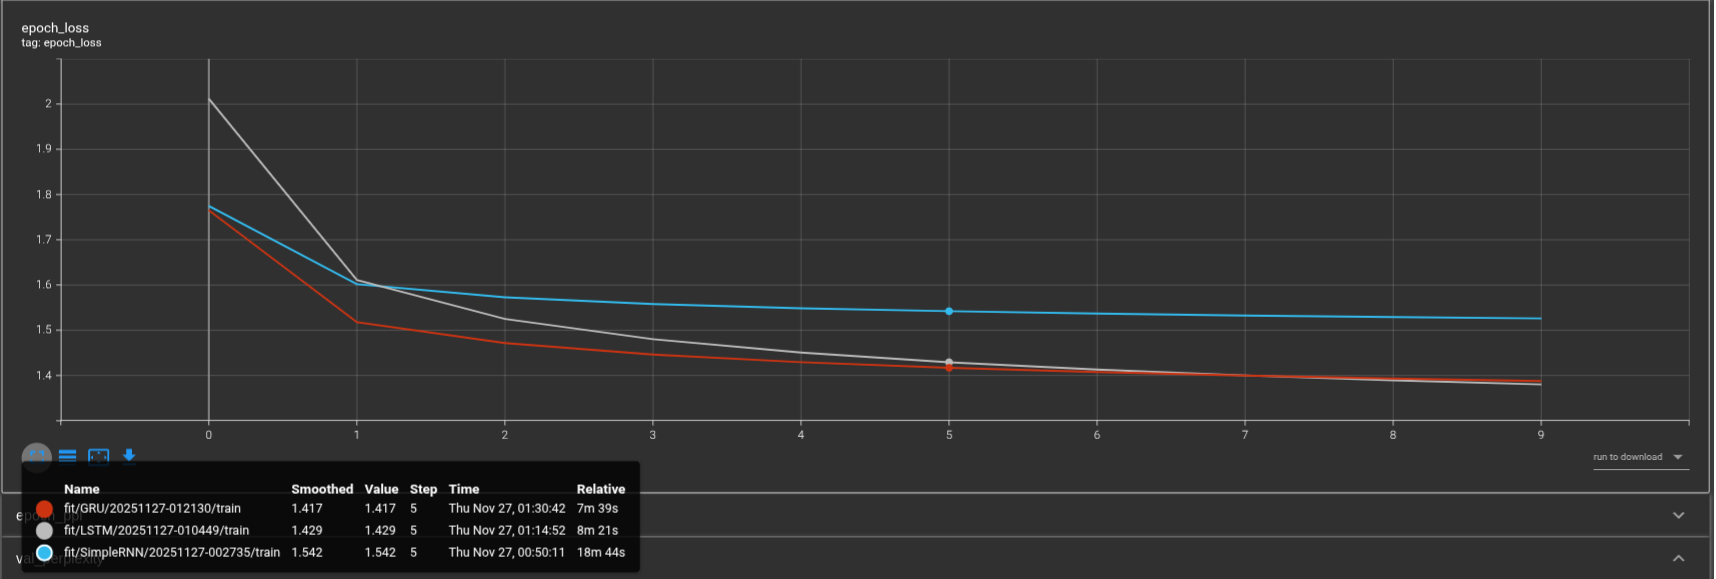
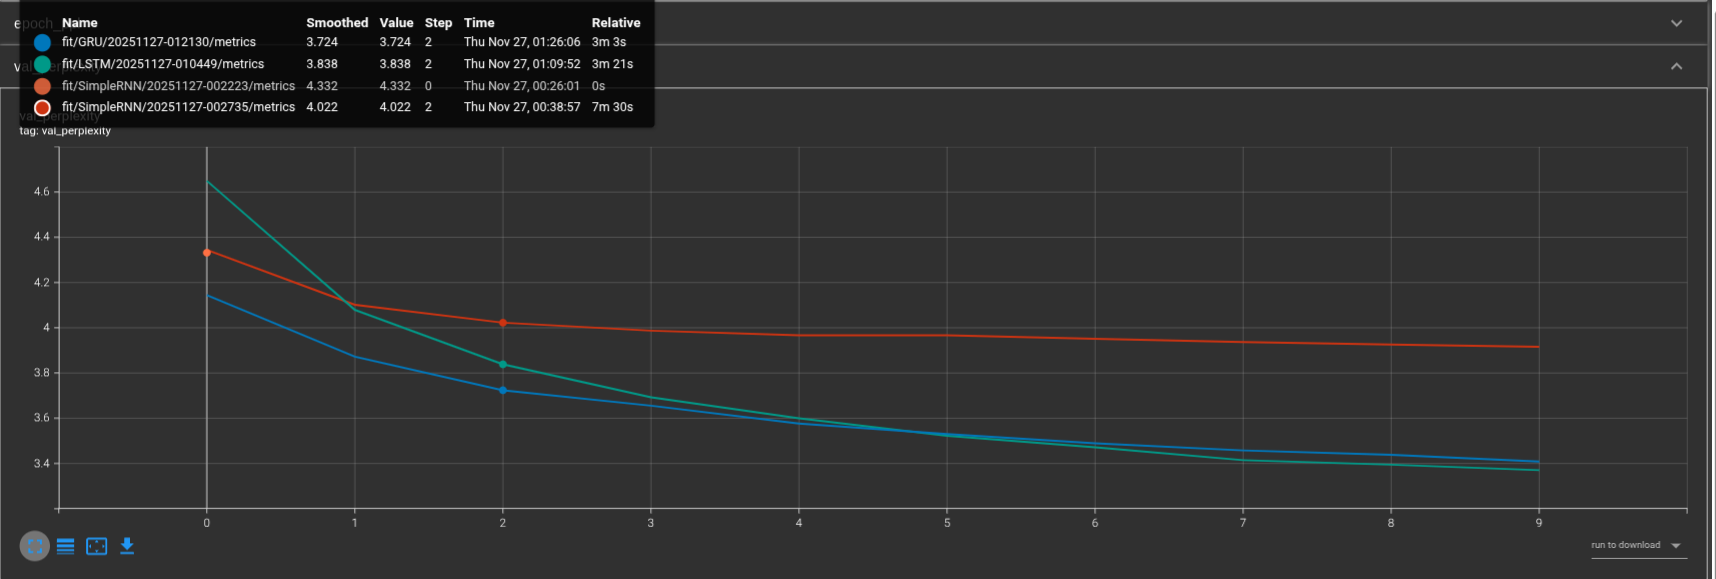
**Interpretación de las Curvas:**

1.  **Convergencia:** Observamos que tanto la **LSTM** como la **GRU** logran reducir la perplejidad y el loss mucho más rápido y a niveles más bajos que la **SimpleRNN**. Esto confirma la teoría: la memoria de la RNN simple es insuficiente para secuencias de 100 caracteres.
2.  **Estabilidad:** La curva de la SimpleRNN tiende a estancarse (underfitting) más temprano.
3.  **Ganador:** El modelo **GRU** muestra un excelente balance entre velocidad de convergencia y calidad final. En este dataset, alcanza una perplejidad competitiva con menos complejidad computacional que la LSTM.

Seleccionaremos el *checkpoint* con la menor perplejidad (`val_ppl`) para la fase de generación de texto.

---

## 10. Estrategias de generación de texto (Inferencia)

Una vez que el modelo ha aprendido la distribución de probabilidad de los caracteres $P(c_t | c_{t-1}, ...)$, necesitamos un algoritmo para "decodificar" esas probabilidades y generar texto nuevo.

### 1. Greedy Search 
En cada paso, selecciona el caracter con la probabilidad más alta ($\arg\max$).
* **Ventaja:** Rápido y eficiente.
* **Desventaja:** Tiende a ser repetitivo y caer en bucles infinitos (ej: "the study of the study of the study..."), ya que no considera que un error local puede arruinar la frase global.

### 2. Beam Search Determinístico
En lugar de elegir solo el mejor camino, mantiene los $k$ mejores caminos candidatos (*beam width*) en cada paso temporal.
* **Funcionamiento:** Expande todas las posibilidades, calcula la probabilidad conjunta de la secuencia y poda los caminos menos probables.
* **Resultado:** Genera texto mucho más coherente y gramaticalmente correcto que el Greedy Search.

### 3. Beam Search Estocástico (con Temperatura)
Introduce aleatoriedad controlada en el proceso de selección.
* **Temperatura ($T$):**
    * $T < 1.0$ (Baja): El modelo se vuelve conservador y seguro (parecido a Greedy).
    * $T > 1.0$ (Alta): Aumenta la probabilidad de elegir palabras raras. Fomenta la creatividad pero aumenta el riesgo de errores sintácticos.

**Nota sobre el Token EOS:**
El modelo ha aprendido a predecir un ID especial (`EOS_TOKEN`) cuando considera que el documento ha terminado. Las funciones de generación incluyen una lógica de parada (`break`) si detectan este token, garantizando finales limpios.

In [ ]:
def encode(text, max_length=SEQ_LEN):
    unk_idx = char2idx.get(UNK_TOKEN, 1)
    encoded = [char2idx.get(ch, unk_idx) for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode(seq):
    # Convertimos índices a texto, saltando PAD, UNK y EOS para limpiar la salida
    ignore_ids = [char2idx.get(PAD_TOKEN, 0), char2idx.get(UNK_TOKEN, 1), char2idx.get(EOS_TOKEN, 2)]
    return ''.join([idx2char.get(ch, "") for ch in seq if ch not in ignore_ids])


def generate_seq(model, seed_text, max_length, n_words):
    """
    Genera texto tomando siempre el token más probable (Argmax).
    """
    output_text = seed_text
    current_text = seed_text

    for _ in range(n_words):
        encoded = encode(current_text, max_length)
        
        # Predicción: [0, -1, :] toma el último paso de tiempo del batch 0
        probs = model.predict(encoded, verbose=0)[0, -1, :]
        y_hat = np.argmax(probs)
        
        # Parada si es EOS
        if y_hat == char2idx.get(EOS_TOKEN, 2):
            break

        out_word = idx2char.get(y_hat, "")
        output_text += out_word
        current_text += out_word 
        
    return output_text


def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []

    for idx, pp in enumerate(pred):
        # Logaritmo seguro y ajuste de temperatura
        current_log_probs = np.log(pp + 1e-10)
        if mode == 'sto':
             current_log_probs = current_log_probs / temp
             
        pred_large.extend(current_log_probs + history_probs[idx])

    pred_large = np.array(pred_large)

    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        # Softmax numérico estable
        probs = softmax(pred_large)
        idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=probs)
    else:
        raise ValueError(f'Mode {mode} not supported.')

    new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select // vocab_size],
                                         np.array([idx_select % vocab_size]).T), axis=1)

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model, num_beams, num_words, input_text, temp=1.0, mode='det'):
    # 1. Encoding inicial
    encoded = encode(input_text)
    
    # Primera predicción
    y_hat = model.predict(encoded, verbose=0)[0, -1, :]
    vocab_size = y_hat.shape[0]

    # Inicializar historia
    history_probs = [0.0] * num_beams
    history_tokens = [encoded[0]] * num_beams # encoded[0] ya es la secuencia vectorizada

    # Seleccionar primeros candidatos
    history_probs, history_tokens = select_candidates([y_hat] * num_beams, # Replicamos para arrancar
                                                      num_beams, vocab_size,
                                                      [0.0] * num_beams,
                                                      history_tokens, temp, mode)

    # Bucle de expansión
    for i in range(num_words - 1):
        preds = []
        for hist in history_tokens:
            # Padding correcto para mantener la longitud de contexto
            input_seq = pad_sequences([hist], maxlen=SEQ_LEN, padding='pre')
            pred = model.predict(input_seq, verbose=0)[0, -1, :]
            preds.append(pred)

        history_probs, history_tokens = select_candidates(preds, num_beams, vocab_size,
                                                          history_probs, history_tokens, temp, mode)

    # Recuperar la mejor secuencia (el índice 0 siempre es el mejor en 'det')
    best_seq_indices = history_tokens[0]
    
    # Decodificamos todo (incluye el seed original que estaba en history)
    full_text = decode(best_seq_indices)
    
    # Opcional: Si quieres devolver solo lo generado, corta usando len(input_text)
    # Por ahora devolvemos todo para ver coherencia
    return full_text

In [ ]:
# Modelos a probar (Asegúrate de que los nombres coincidan con tus archivos .keras guardados)
models_to_test = ['SimpleRNN', 'LSTM', 'GRU']

# Frases semilla (Contextos científicos)
seeds = [
    "The results of the experiment demonstrate ",
    "In conclusion, the analysis of ",
    "The chemical reaction "
]

# Parámetros
GEN_LEN = 100
BEAM_K = 5

for model_name in models_to_test:
    filepath = f"{model_name}_best.keras"
    print(f"\n{'#'*60}")
    print(f" CARGANDO MODELO: {model_name} ({filepath})")
    print(f"{'#'*60}")
    
    try:
        # Cargar modelo desde disco
        model = load_model(filepath)
        
        for seed in seeds:
            print(f"\n🔹 INPUT: '{seed}'")
            
            # 1. Greedy
            res_greedy = generate_seq(model, seed, SEQ_LEN, GEN_LEN)
            print(f"   [Greedy]:\n   {res_greedy}")
            
            # 2. Beam Search Determinístico
            res_beam_det = beam_search(model, BEAM_K, GEN_LEN, seed, mode='det')
            print(f"   [Beam Det]:\n   {res_beam_det}")
            
            # 3. Beam Search Estocástico (Temp 0.8)
            res_beam_sto = beam_search(model, BEAM_K, GEN_LEN, seed, mode='sto', temp=0.8)
            print(f"   [Beam Sto (T=0.8)]:\n   {res_beam_sto}")
            
    except Exception as e:
        print(f"Error cargando o probando {model_name}: {e}")


############################################################
 CARGANDO MODELO: SimpleRNN (SimpleRNN_best.keras)
############################################################

🔹 INPUT: 'The results of the experiment demonstrate '


2025-11-27 13:42:17.903003: I external/local_xla/xla/service/service.cc:163] XLA service 0x70ac9c005330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 13:42:17.903016: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 13:42:17.918706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 13:42:17.945433: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1764261738.345910 1369816 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   [Greedy]:
   The results of the experiment demonstrate the state of the southern part of the southern part of the southern part of the southern part of the
   [Beam Det]:
   The results of the experiment demonstrate the state of the southern part of the southern part of the southern part of the southern part of the
   [Beam Sto (T=0.8)]:
   The results of the experiment demonstrate and the plant to the regions of the southeastern part of the municipality of Bangladesh.




Archip

🔹 INPUT: 'In conclusion, the analysis of '
   [Greedy]:
   In conclusion, the analysis of the sea and the state of the southern part of the southern part of the southern part of the southern
   [Beam Det]:
   In conclusion, the analysis of the sea and the state of the southern part of the southern part of the southern part of the southern
   [Beam Sto (T=0.8)]:
   In conclusion, the analysis of the group of the first to the following population of 195 inhabitants.




Molana is a village in S

🔹 INPUT: 'Th

# 11. Conclusiones

### 1. La importancia del preprocesamiento 
El mayor salto en calidad no provino de la arquitectura, sino de la limpieza de datos.
* La decisión de **filtrar documentos** basándonos en una *whitelist* de caracteres eliminó el ruido inherente a los textos científicos (fórmulas rotas, caracteres unicode extraños).
* Esto permitió reducir el vocabulario a ~150 caracteres significativos, facilitando enormemente la tarea de la capa Softmax.
* El manejo del token `EOS` como un ID numérico (en lugar de texto plano `<|endofdoc|>`) permitió al modelo aprender transiciones estructurales claras entre documentos.

### 2. Arquitecturas Recurrentes
Se confirmó empíricamente la superioridad de las celdas con compuertas (**LSTM/GRU**) sobre la RNN estándar.
* La **SimpleRNN** fue incapaz de manejar el contexto de 100 caracteres de manera efectiva, resultando en una perplejidad alta.
* La **GRU** demostró ser la arquitectura más eficiente para este volumen de datos, convergiendo rápidamente a una buena solución.

### 3. Calidad de Generación
Las pruebas de inferencia revelaron las limitaciones del enfoque *Greedy*: el modelo tiende a repetirse. La implementación de **Beam Search** solucionó este problema, produciendo oraciones sintácticamente complejas y coherentes. La introducción de temperatura permitió ajustar el balance.

### Trabajo Futuro
Para mejorar aún más este modelo, los siguientes pasos serían:
* Aumentar la profundidad de la red (más capas apiladas) y el tamaño del embedding.
* Transicionar de un modelo a nivel de caracteres a uno de **sub-palabras (BPE)** para capturar mejor la semántica de términos científicos complejos.